In [1]:
import random
import numpy as np
import tensorflow as tf
from ffobjects import FFModel, FFLayer, FFConstants

def set_seed(seed=100):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

In [2]:
# CONFIGURATION
BATCH_SIZE = 128
NUM_CLASS = 5 # Only digits 0 to 4 are positive samples
IMG_SHAPE = (28, 28, )

# Data loading and preparation

## Positive and Negative data split

Forward-forward algorithm requires positive data in the positive forward pass, and negative data in the negative forward pass.

This demo uses digits 0, 1, 2, 3, 4 as the positive data and the rest as the negative data.

In [3]:
# Load data
ds_train, ds_valid = map(tf.data.Dataset.from_tensor_slices, 
                         tf.keras.datasets.mnist.load_data())

# Preprocess, split into pos/neg data, batch, cache
@tf.function
def data_preprocess(X, y):
    return (tf.cast(X, tf.float32)/255., tf.cast(y, tf.int32))

ds_train_pos = ds_train.map(data_preprocess).filter(lambda X, y: y <  5).batch(BATCH_SIZE, drop_remainder=True).cache()
ds_train_neg = ds_train.map(data_preprocess).filter(lambda X, y: y >= 5).batch(BATCH_SIZE, drop_remainder=True).cache()
ds_valid_pos = ds_valid.map(data_preprocess).filter(lambda X, y: y <  5).batch(BATCH_SIZE, drop_remainder=True).cache()
ds_valid_neg = ds_valid.map(data_preprocess).filter(lambda X, y: y >= 5).batch(BATCH_SIZE, drop_remainder=True).cache()

## Overlay labels on X

Because forward-forward only distinguish between positive and negative data, in principle, labels of the positive data won't be used at all.

Superwised-wise FF works by overlaying data labels on the data itself. 

### Helper functions

In [4]:
# Constants for overlaying data labels on the data
# OVERLAY_LABELS: shape (5, 28, 28)
OVERLAY_LABELS = tf.reshape(
    tf.one_hot(tf.range(NUM_CLASS), depth=tf.reduce_prod(IMG_SHAPE)), 
    (NUM_CLASS, ) + IMG_SHAPE
)

# OVERLAY_LABELS_SUM: shape (1, 28, 28), the first 5 elements are 1., rest are 0.
OVERLAY_LABELS_SUM = tf.reduce_sum(OVERLAY_LABELS, keepdims=True, axis=0)

# OVERLAY_DEFAULT: shape (1, 28, 28), the first 5 elements are 0.2, rest are 0.
OVERLAY_DEFAULT = OVERLAY_LABELS_SUM/NUM_CLASS

# OVERLAY_BITMASK: shape (1, 28, 28), the first 5 elements are 0., rest are 1.
OVERLAY_BITMASK = 1. - OVERLAY_LABELS_SUM

@tf.function
def randomize_y(X, y):
    '''For training supervised-FF, we need fake labels for negative data'''
    y = tf.random.uniform(tf.shape(y), maxval=NUM_CLASS, dtype=tf.int32)
    return X, y

@tf.function
def overlay_y_in_X(X, y):
    '''For training supervised-FF, we need real labels overlayed'''
    X = X * OVERLAY_BITMASK + tf.gather(OVERLAY_LABELS, y)
    return X, y

@tf.function
def overlay_default_in_X(X):
    '''For predicting or evaluating supervised-FF, we need default labels overlayed'''
    X = X * OVERLAY_BITMASK + OVERLAY_DEFAULT
    return X

@tf.function
def overlay_each_label_in_one_X(X):
    '''For predicting or evaluating supervised-FF, we need to replicate X NUM_CLASS times, and in each of which overlays a label'''
    _X = tf.repeat(X, NUM_CLASS, axis=0)
    _y = tf.tile(tf.range(NUM_CLASS), [tf.shape(X)[0], ])
    _X = overlay_y_in_X(_X, _y)[0]
    return _X

### Finalize datasets for training and evaluation

As mentioned, we have two types of datasets - for supervised-wise FF, and unsupervised-wise FF. 
1. For training datasets, we only overlay labels for supervised-wise FF.
2. For evaulation datasets, they consist of 2 parts. 
    1. The 1st part serves as softmax evaluation, and we only overlay labels for supervised-wise FF.
    2. The 2nd part serves as goodness evaulation, and we overlay labels for both FFs. In principle, the goodness evaulation for unsupervised-wise should be bad because it is not supposed to be able to indentify label-overlayed data. 

In [5]:
@tf.function
def eval_unsupervised(X, y):
    '''Create X for evaluating unsupervised-wise FF'''
    part1 = X
    part2 = overlay_each_label_in_one_X(X)
    return tf.concat([part1, part2], 0), y

@tf.function
def eval_supervised(X, y):
    '''Create X for evaluating supervised-wise FF'''
    part1 = overlay_default_in_X(X)
    part2 = overlay_each_label_in_one_X(X)
    return tf.concat([part1, part2], 0), y

set_seed(300)

# "unsupervised" data: labels are not embedded in the images.
u_train = (ds_train_pos, ds_train_neg)
u_valid = (ds_valid_pos, ds_valid_neg)

u_valid_for_eval = [
    ('train', (u_train[0].map(eval_unsupervised).cache(),
               u_train[1].map(eval_unsupervised).cache())),
    ('valid', (u_valid[0].map(eval_unsupervised).cache(),
               u_valid[1].map(eval_unsupervised).cache())),
]

# "supervised" data: labels are embedded in the training images.
s_train = (ds_train_pos.map(overlay_y_in_X), ds_train_neg.map(randomize_y).map(overlay_y_in_X))
s_valid = (ds_valid_pos, ds_valid_neg)

s_valid_for_eval = [
    ('train', (s_train[0].map(eval_supervised).cache(),
               s_train[1].map(eval_supervised).cache())),
    ('valid', (s_valid[0].map(eval_supervised).cache(),
               s_valid[1].map(eval_supervised).cache())),
]

# Metric and Loss functions for FF layers

In [6]:
# For Hidden layers    
class FF_HiddenLayer_Loss(tf.keras.losses.BinaryCrossentropy):
    '''Implementing the goodness function suggested by the paper.'''
    def __init__(self, threshold):
        super().__init__(from_logits=True, name='ff_binary_crossentropy')
        self.threshold = tf.cast(threshold, tf.float32)
        
    def __call__(self, y_true, y_pred):
        axis = tf.range(tf.rank(y_pred))[1:]
        y_pred = tf.reduce_sum(y_pred**2, axis=axis)
        y_pred = y_pred - self.threshold
        return super().__call__(y_true, y_pred)

class FF_HiddenLayer_Metric(tf.keras.metrics.BinaryCrossentropy):
    '''Implementing the goodness function suggested by the paper.'''
    
    def __init__(self):
        super().__init__(from_logits=True, name='ff_metric_binary_crossentropy')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        m = tf.shape(y_true)[0]
        y_pred = y_pred[:m]
        
        axis = tf.range(tf.rank(y_pred))[1:]
        y_pred = tf.reduce_sum(y_pred**2, axis=axis)
        return super().update_state(y_true, y_pred, sample_weight)
    
# For prediction layers
class FF_Softmax_Accuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        m = tf.shape(y_true)[0]
        y_pred = y_pred[:m]
        return super().update_state(y_true, y_pred, sample_weight)
    
class FF_Goodness_Accuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        m = tf.shape(y_true)[0]
        y_pred = tf.reshape(y_pred[m:], (m, -1))
        return super().update_state(y_true, y_pred, sample_weight)

# Other shared functions

In [7]:
@tf.function
def preNorm(X):
    '''For preNormalization layer'''
    axis = tf.range(tf.rank(X))[1:]
    norm = tf.math.sqrt(tf.reduce_sum(X**2, axis=axis, keepdims=True))
    return X/(norm + 1e-7)

# Dense models

Three models each consists of Dense layers are trained:
- A `tf.keras.Model` that uses backprop as a baseline
- A `FFModel` that expects for "unsupervised" data
- A `FFModel` that expects for "supervised" data

In [8]:
def ff_dense_block(units, activation, lr, th, idx, x):
    '''
          output 1         output 2
            ^                ^
    x --> Dense --> pre-Normalization
    ^
    input
    
    Args:
        units, activation: passed to `tf.keras.layers.Dense`
        lr: learning rate
        th: FF_HiddenLayer_Loss threshold
        idx: numbering for the block to be created
        x: input keras tensor to the block
    '''
    
    activity = FFLayer(
        tf.keras.layers.Dense, units=units, activation=activation, 
        do_ff=True, 
        metric=FF_HiddenLayer_Metric(),
        loss_fn=FF_HiddenLayer_Loss(threshold=th),
        optimizer=tf.keras.optimizers.Adam(lr), 
        name=f'b{idx}_dense',
    )(x)
    
    normalized = FFLayer(
        tf.keras.layers.Lambda, 
        function=preNorm,  
        name=f'b{idx}_prenorm',
    )(activity)
    
    return activity, normalized

In [9]:
def build_dense_model(seed=100, return_ff_model=True):
    
    set_seed(seed)
    
    b0i = FFLayer(tf.keras.layers.InputLayer, input_shape=IMG_SHAPE, name='input')
    b0o = FFLayer(tf.keras.layers.Flatten, name='input_flatten')(b0i)

    b1a, b1o = ff_dense_block(100, 'relu', 0.0001, 0.1, 1, b0o)
    b2a, b2o = ff_dense_block(100, 'relu', 0.0001, 0.1, 2, b1o)
    b3a, b3o = ff_dense_block(100, 'relu', 0.0001, 0.1, 3, b2o)
    b4a, b4o = ff_dense_block(100, 'relu', 0.0001, 0.1, 4, b3o)

    softmax_opt = tf.keras.optimizers.Adam(0.0001)
    softmax_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    softmax_metric = FF_Softmax_Accuracy()
    goodness_metric = FF_Goodness_Accuracy()
    
    b5a = FFLayer(tf.keras.layers.Concatenate, 
                  name='concat_activities')([b2a, b3a, b4a])
    b5o = FFLayer(tf.keras.layers.Lambda, function=lambda X: tf.reduce_sum(X**2, axis=-1),
                  is_goodness_softmax=True,
                  metric=goodness_metric, 
                  report_metric_pos=True,
                  name='goodness')(b5a)
    
    b6a = FFLayer(tf.keras.layers.Concatenate, 
                  name='concat_preNormed')([b2o, b3o, b4o])
    b6o = FFLayer(tf.keras.layers.Dense, units=NUM_CLASS, activation='linear', 
                  do_ff=False, 
                  metric=softmax_metric,
                  loss_fn=softmax_loss, 
                  optimizer=softmax_opt, 
                  report_metric_pos=True,
                  name='softmax_output')(b6a)
    
    if return_ff_model:
        model = FFModel(inputs=b0i, outputs=[b1a, b2a, b3a, b4a, b5o, b6o], 
                        name='Dense_FF')
        
    else:
        model = tf.keras.Model(inputs=b0i, outputs=b6o, name='Dense_BP')
        model.compile(optimizer=softmax_opt, loss=softmax_loss, metrics=softmax_metric)
    
    return model

In [10]:
%%time
print('training Dense model with backprop')
u_dense_bp = build_dense_model(seed=200, return_ff_model=False)
u_dense_bp_hist = u_dense_bp.fit(u_train[0], validation_data=u_valid[0], epochs=20, verbose=2)

print('\n\ntraining Dense model with unsupervised-wise forward-forward algorithm')
u_dense_ff = build_dense_model(seed=200, return_ff_model=True)
u_dense_ff_hist = u_dense_ff.ff_train(u_train, u_valid_for_eval, epochs=200, eval_every=5)

print('\n\ntraining Dense model with supervised-wise forward-forward algorithm')
s_dense_ff = build_dense_model(seed=200, return_ff_model=True)
s_dense_ff_hist = s_dense_ff.ff_train(s_train, s_valid_for_eval, epochs=200, eval_every=5)

training Dense model with backprop
Epoch 1/20
240/240 - 17s - loss: 1.0622 - sparse_categorical_accuracy: 0.8547 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.9619 - val_ff_binary_crossentropy: 0.0000e+00 - 17s/epoch - 72ms/step
Epoch 2/20
240/240 - 2s - loss: 0.5164 - sparse_categorical_accuracy: 0.9617 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.3875 - val_sparse_categorical_accuracy: 0.9732 - val_ff_binary_crossentropy: 0.0000e+00 - 2s/epoch - 8ms/step
Epoch 3/20
240/240 - 2s - loss: 0.3325 - sparse_categorical_accuracy: 0.9715 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.2651 - val_sparse_categorical_accuracy: 0.9787 - val_ff_binary_crossentropy: 0.0000e+00 - 2s/epoch - 7ms/step
Epoch 4/20
240/240 - 2s - loss: 0.2391 - sparse_categorical_accuracy: 0.9769 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.1974 - val_sparse_categorical_accuracy: 0.9807 - val_ff_binary_crossentropy: 0.0000e+00 - 2s/epoch - 8ms/step
Epoch 5/20

#### Conv2D models

Three models each consists of Conv2D layers are trained:
- A `tf.keras.Model` that uses backprop as a baseline
- A `FFModel` that expects for "unsupervised" data
- A `FFModel` that expects for "supervised" data

In [11]:
def ff_conv2d_block(filters, kernel_size, activation, lr, th, idx, x):
    '''
        output 1  output 2         output 3  output 4
            ^        ^                ^         ^
            ---> Flatten     ---> Flatten       |
            |                |                  |
    x --> Conv2D --> pre-Normalization ----------
    ^
    input
    
    Args:
        filters, kernel_size, activation: passed to 
            `tf.keras.layers.Conv2D`
        lr: learning rate
        th: FF_HiddenLayer_Loss threshold
        idx: numbering for the block to be created
        x: input keras tensor to the block
    '''
    
    activity = FFLayer(
        tf.keras.layers.Conv2D, 
        filters=filters, kernel_size=kernel_size, activation=activation, 
        do_ff=True, 
        metric=FF_HiddenLayer_Metric(),
        loss_fn=FF_HiddenLayer_Loss(threshold=th),
        optimizer=tf.keras.optimizers.Adam(lr), 
        name=f'b{idx}_conv2d',
    )(x)
    
    flattened_activity = FFLayer(
        tf.keras.layers.Flatten,
        name=f'b{idx}_flattened_activity'
    )(activity)
    
    normalized = FFLayer(
        tf.keras.layers.Lambda, 
        function=preNorm,  
        name=f'b{idx}_prenorm',
    )(activity)
    
    flattened_normalized = FFLayer(
        tf.keras.layers.Flatten,
        name=f'b{idx}_flattened_preNormed'
    )(normalized)
    
    return activity, flattened_activity, flattened_normalized, normalized

In [12]:
def build_conv2d_model(seed=100, return_ff_model=True):
    
    set_seed(seed)

    b0i = FFLayer(tf.keras.layers.InputLayer, input_shape=IMG_SHAPE, name='input')
    b0o = FFLayer(tf.keras.layers.Lambda, function=lambda X: tf.expand_dims(X, -1), name='input_expand_dims')(b0i)

    b1a, b1fa, b1fp, b1o = ff_conv2d_block(100, (28, 28), 'relu', 0.0001, 0.1, 1, b0o)
    b2a, b2fa, b2fp, b2o = ff_conv2d_block(100, ( 1,  1), 'relu', 0.0001, 0.1, 2, b1o)
    b3a, b3fa, b3fp, b3o = ff_conv2d_block(100, ( 1,  1), 'relu', 0.0001, 0.1, 3, b2o)
    b4a, b4fa, b4fp, b4o = ff_conv2d_block(100, ( 1,  1), 'relu', 0.0001, 0.1, 4, b3o)

    softmax_opt = tf.keras.optimizers.Adam(0.0001)
    softmax_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    softmax_metric = FF_Softmax_Accuracy()
    goodness_metric = FF_Goodness_Accuracy()
    
    b5a = FFLayer(tf.keras.layers.Concatenate, 
                  name='concat_activities')([b2fa, b3fa, b4fa])
    b5o = FFLayer(tf.keras.layers.Lambda, function=lambda X: tf.reduce_sum(X**2, axis=-1),
                  is_goodness_softmax=True,
                  metric=goodness_metric, 
                  report_metric_pos=True,
                  name='goodness')(b5a)
    
    b6a = FFLayer(tf.keras.layers.Concatenate, 
                  name='concat_preNormed')([b2fp, b3fp, b4fp])
    b6o = FFLayer(tf.keras.layers.Dense, units=NUM_CLASS, activation='linear', 
                  do_ff=False, 
                  metric=softmax_metric,
                  loss_fn=softmax_loss, 
                  optimizer=softmax_opt, 
                  report_metric_pos=True,
                  name='softmax_output')(b6a)
    
    if return_ff_model:
        model = FFModel(inputs=b0i, outputs=[b1a, b2a, b3a, b4a, b5o, b6o], 
                        name='Conv2D_FF')
        
    else:
        model = tf.keras.Model(inputs=b0i, outputs=b6o, name='Conv2D_BP')
        model.compile(optimizer=softmax_opt, loss=softmax_loss, metrics=softmax_metric)
    
    return model

In [13]:
%%time
print('training Conv2D model with backprop')
u_conv2d_bp = build_conv2d_model(seed=200, return_ff_model=False)
u_conv2d_bp_hist = u_conv2d_bp.fit(u_train[0], validation_data=u_valid[0], epochs=20, verbose=2)

print('\n\ntraining Conv2D model with unsupervised-wise forward-forward algorithm')
u_conv2d_ff = build_conv2d_model(seed=200, return_ff_model=True)
u_conv2d_ff_hist = u_conv2d_ff.ff_train(u_train, u_valid_for_eval, epochs=200, eval_every=5)

print('\n\ntraining Conv2D model with supervised-wise forward-forward algorithm')
s_conv2d_ff = build_conv2d_model(seed=200, return_ff_model=True)
s_conv2d_ff_hist = s_conv2d_ff.ff_train(s_train, s_valid_for_eval, epochs=200, eval_every=5)

training Conv2D model with backprop
Epoch 1/20
240/240 - 4s - loss: 0.8554 - sparse_categorical_accuracy: 0.9414 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.5494 - val_sparse_categorical_accuracy: 0.9766 - val_ff_binary_crossentropy: 0.0000e+00 - 4s/epoch - 18ms/step
Epoch 2/20
240/240 - 3s - loss: 0.4466 - sparse_categorical_accuracy: 0.9737 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.3492 - val_sparse_categorical_accuracy: 0.9812 - val_ff_binary_crossentropy: 0.0000e+00 - 3s/epoch - 14ms/step
Epoch 3/20
240/240 - 3s - loss: 0.2992 - sparse_categorical_accuracy: 0.9806 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.2466 - val_sparse_categorical_accuracy: 0.9844 - val_ff_binary_crossentropy: 0.0000e+00 - 3s/epoch - 14ms/step
Epoch 4/20
240/240 - 3s - loss: 0.2143 - sparse_categorical_accuracy: 0.9858 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.1853 - val_sparse_categorical_accuracy: 0.9854 - val_ff_binary_crossentropy: 0.0000e+00 - 3s/epoch - 14ms/step
Epoch 5/

#### Summary

<table>
    <thead>
        <tr>
            <th></th>
            <th>algorithm</th>
            <th>epochs</th>
            <th>best accuracy by trained softmax</th>
            <th>best accuracy by goodness softmax</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=3>Dense Model</td>
            <td>BP</td>
            <td>20</td>
            <td>99.2</td>
            <td>--</td>
        </tr>
        <tr>
            <td>FF (unsupervised-wise)</td>
            <td rowspan=2>200</td>
            <td>96.2</td>
            <td>22.7</td>
        </tr>
        <tr>
            <td>FF (supervised-wise)</td>
            <td>96.4</td>
            <td>78.1</td>
        </tr>
        <tr>
            <td rowspan=3>Conv2D Model</td>
            <td>BP</td>
            <td>20</td>
            <td>99.2</td>
            <td>--</td>
        </tr>
        <tr>
            <td>FF (unsupervised-wise)</td>
            <td rowspan=2>200</td>
            <td>95.1</td>
            <td>41.5</td>
        </tr>
        <tr>
            <td>FF (supervised-wise)</td>
            <td>94.0</td>
            <td>71.7</td>
        </tr>
    </tbody>
</table>

- It's consistent with the paper that BP (Backprop) does better than FF (Forward-forward) even in less epochs.
- It's reasonable that the "accuracy by goodness softmax" is very poor with "unsupervised" data, however, it's interesting that it can reach 41.5% as well
- "Accuracy by goodness softmax" is pretty sensitive to initialization
- No hyperparameters tuned for best performing models. They are just for demo.
- Known major difference between this and the paper's implementation is that my layers are smaller and my training sets are smaller.

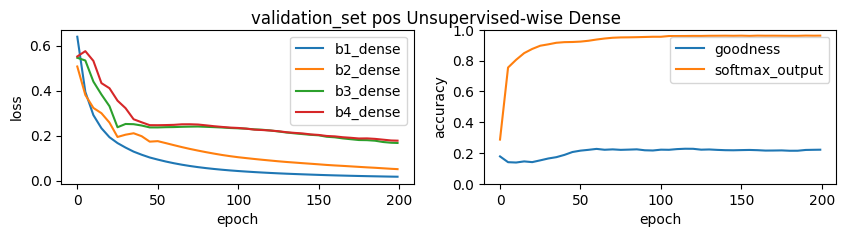

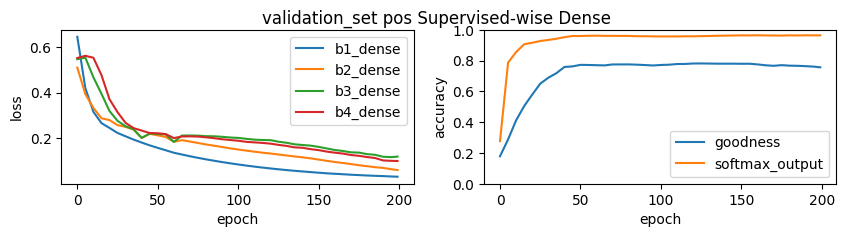

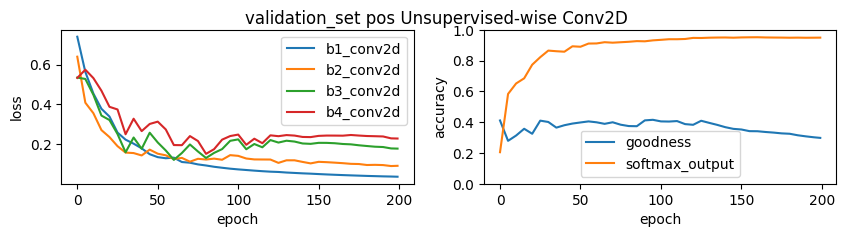

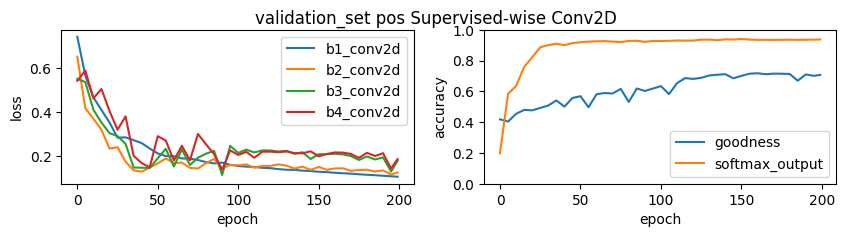

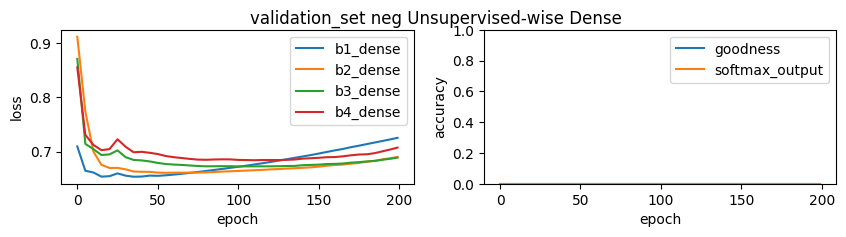

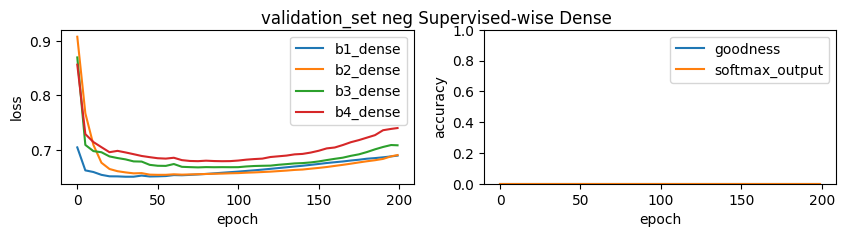

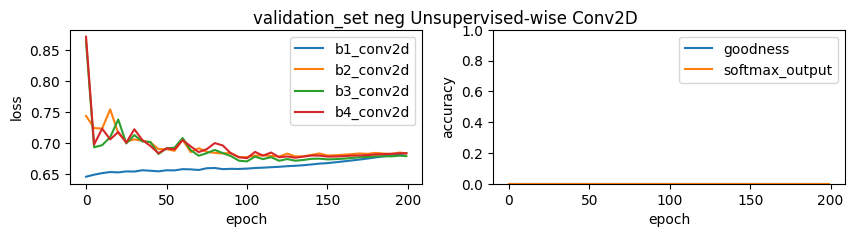

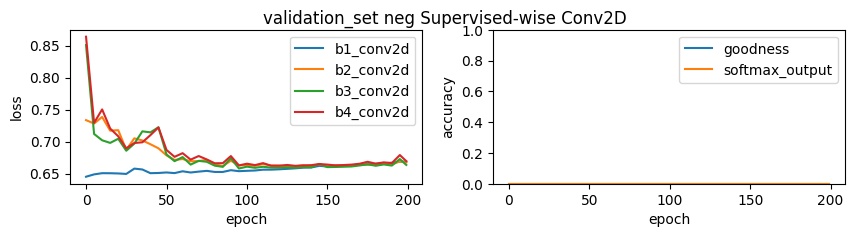

In [14]:
import pandas as pd
from matplotlib import pyplot as plt

for _pass in [FFConstants.POS, FFConstants.NEG]:
    for name, hist in [('Unsupervised-wise Dense', u_dense_ff_hist),
                       ('Supervised-wise Dense', s_dense_ff_hist),
                       ('Unsupervised-wise Conv2D', u_conv2d_ff_hist),
                       ('Supervised-wise Conv2D', s_conv2d_ff_hist),
                      ]:
        df = pd.DataFrame(
            [x['valid'][_pass] for x in hist],
            index = [x['epoch'] for x in hist]
        )

        plot1 = set(['b1_dense', 'b2_dense', 'b3_dense', 'b4_dense',
                     'b1_conv2d', 'b2_conv2d', 'b3_conv2d', 'b4_conv2d'])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
        df[sorted(set(df.columns.tolist()) & plot1)].plot(
            xlabel='epoch', ylabel='loss', ax=ax1)
        df[['goodness', 'softmax_output']].plot(
            xlabel='epoch', ylabel='accuracy', ylim=(0,1), ax=ax2)
        fig.suptitle(f'validation_set {_pass} {name}')
        plt.show()

In [15]:
u_dense_ff.summary()

Model: "Dense_FF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28)]     0           []                               
                                                                                                  
 input_flatten (Flatten)        (None, 784)          0           ['input[0][0]']                  
                                                                                                  
 b1_dense (Dense)               (None, 100)          78500       ['input_flatten[0][0]']          
                                                                                                  
 b1_prenorm (Lambda)            (None, 100)          0           ['b1_dense[0][0]']               
                                                                                           

In [16]:
for _pass in [FFConstants.POS, FFConstants.NEG]:
    for name, hist in [('Unsupervised-wise Dense', u_dense_ff_hist),
                       ('Supervised-wise Dense', s_dense_ff_hist),
                       ('Unsupervised-wise Conv2D', u_conv2d_ff_hist),
                       ('Supervised-wise Conv2D', s_conv2d_ff_hist),
                      ]:
        df = pd.DataFrame(
            [x['valid'][_pass] for x in hist],
            index = [x['epoch'] for x in hist]
        )
        
        print(name)
        print(df['goodness'].max())
        print(df['softmax_output'].max())        

Unsupervised-wise Dense
0.22714844
0.96171874
Supervised-wise Dense
0.7810547
0.9638672
Unsupervised-wise Conv2D
0.41503906
0.9511719
Supervised-wise Conv2D
0.7173828
0.9398438
Unsupervised-wise Dense
0.0
0.0
Supervised-wise Dense
0.0
0.0
Unsupervised-wise Conv2D
0.0
0.0
Supervised-wise Conv2D
0.0
0.0
